In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

import gym
from gym import spaces
from gym.utils import seeding

In [2]:
class PID:
    def __init__(self, p=5, i=0.1, d=1):
        self.p = p
        self.i = i
        self.d = d
        self.i_value = 0

    def control(self, e, e_d):
        '''
        This function calculates control output
        @params:
            e: angular error
            e_d: angular velocity error
        '''
        self.i_value += e
        self.i_value = np.clip(self.i_value, -10000, 10000)
        return self.p * e + self.i * self.i_value + self.d * e_d

# linear model

In [6]:
class Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.I = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        I = self.I
        g = self.g
        l = self.l
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = I*(M+m)+M*m*l**2 # denominator for the A and B matrices
        A = (M+m)*m*g*l/p
        B = -F1*(M+m)/p
        C = F0*m*l/p
        D = -m*l/p
        E = -m*m*g*l*l/p
        F = F1*m*l/p
        G = -F0*(I+m*l*l)/p
        H = (I+m*l*l)/p
        
        
        x_r = 0.5
        e1 = target[0] - phi
        e2 = target[1] - phi_d
        e3 = x_r - x
        e4 = 0 - x_d

        x_d_r = ( kp1*e1+kd1*e2-A*phi-B*phi_d+E*D/H*phi+F*D/H*phi_d+G*D/H*x_d+D/H*kd2*x_d -D/H*kp2*e3) / (C + D/H*kp2*self.dt)
        u = -E/H*phi -F/H*phi_d-G/H*x_d +kp2*self.dt*x_d_r/H + kp2*e3/H  -kd2/H*x_d
        
        
        
        u = kp1*e1+kd1*e2+ kp2*e3+kd2*e4


        # acceleration calculation
        
        phi_dd = A * phi + B * phi_d + C * x_d + D * u
        x_dd = E * phi + F * phi_d + G * x_d + H * u

        # semi-implicit euler
        for _ in range(1):
            x += self.dt * x_d / 1
            x_d += self.dt * x_dd / 1
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 1
            phi_d += self.dt * phi_dd / 1
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2# + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r, 'u':u}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 0.5, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

# testing

In [4]:
phi_l = []
phi_d_l = []
x_l = []
x_d_l = []
x_d_r_l = []
u_l = []

def episode_run(x1, x2, x3, x4):
    env = Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 799
    obs = env.reset()
    
    phi_l.append(obs[2])
    x_l.append(obs[0])
    x_d_r_l.append(0)
    x_d_l.append(obs[1])
    phi_d_l.append(obs[3])
    u_l.append(0)


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        u_l.append(info['u'])
        x_d_l.append(obs[1])
        phi_d_l.append(obs[3])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [7]:
# episode_run(240.00, 34.10, 60.00, 79.18) # best proposed
episode_run(-200.0,-39.48,-20.821,-60.76) # best baseline double loop PD

-53.47132256728941

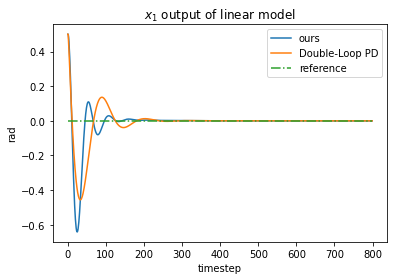

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_l[:800], label='ours') # -7.499676092201453
ax.plot(phi_l[-800:], label='Double-Loop PD') # -7.499676092201453
ax.plot([0]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_1$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x1linear.png", dpi=500, format="png")

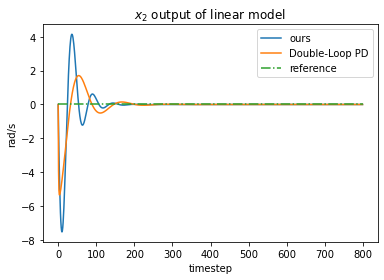

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_d_l[:800], label='ours') # -7.499676092201453
ax.plot(phi_d_l[-800:], label='Double-Loop PD')
ax.plot([0]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_2$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x2linear.png", dpi=500, format="png")

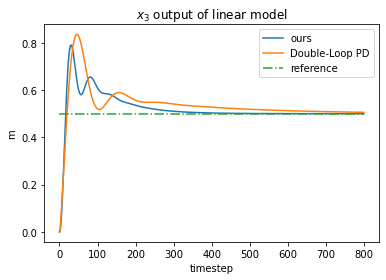

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_l[:800], label='ours') # -7.499676092201453
ax.plot(x_l[-800:], label='Double-Loop PD') # -7.499676092201453
ax.plot([0.5]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_3$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('m')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x3linear.png", dpi=500, format="png")

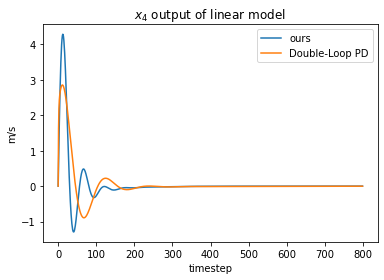

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l[:800], label='ours') # -7.499676092201453
ax.plot(x_d_l[-800:], label='Double-Loop PD') # -7.499676092201453
# ax.plot(x_d_r_l, linestyle="-.", label='reference $x_{4d}$') # -8.540721246923548

plt.title('$x_4$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('m/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4linear.png", dpi=500, format="png")

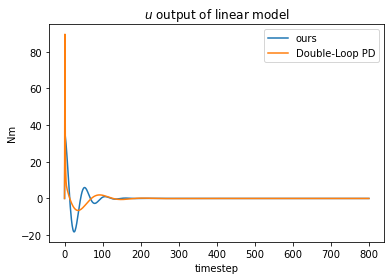

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(u_l[:800], label='ours') # -7.499676092201453
ax.plot(u_l[-800:], label='Double-Loop PD')

plt.title('$u$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('Nm')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/ulinear.png", dpi=500, format="png")

# BO for linear

In [302]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (-200, 200), 'x2': (-100, 100), \
           'x3': (-200, 200), 'x4': (-100, 100)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=2,
)

optimizer.maximize(
    init_points=50,
    n_iter=200,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
| 3         | -7.85e+05 | -80.14    | -46.63    | 48.45     | 5.828     |
| 12        | -2.085e+0 | 26.86     | -14.49    | -25.3     | 55.31     |
| 19        | -3.957e+0 | -96.1     | -22.62    | 132.8     | 47.35     |
| 51        | -3.437e+0 | -90.14    | -18.1     | 133.2     | 49.04     |


## Nonlinear

In [21]:
class Nonlinear_Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.J = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        J = self.J
        g = self.g
        l = self.l
        dt = self.dt
        
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = (M+m)*(J+m*l**2) - m**2*l**2*np.cos(phi)**2 # denominator for the A and B matrices
        
        
        e1 = target[0] - phi
        e2 = target[1] - phi_d
        x_r = 0.5
        e3 = x_r - x
        e4 = 0 - x_d
        
        x_d_r = p*(kp1*e1+kd1*e2) + F1*(M+m)*phi_d + m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) - (M+m)*m*g*l*np.sin(phi) # - F0*m*l*np.cos(phi)*x_d
        x_d_r += m*l*np.cos(phi)/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                                              +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        x_d_r += m*l*np.cos(phi)*(p/(J+m*l*l)*(-kd2*x_d+kp2*(x_r-x)))
        x_d_r /= (F0*m*l*np.cos(phi)-p*m*l*np.cos(phi)*kp2*dt/(J+m*l*l))
        
        u = 1/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                           +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        u += p/(J+m*l*l) * (kp2*(dt*x_d_r+x_r-x) - kd2*x_d)
        
        u = kp1*e1+kd1*e2+ kp2*e3+kd2*e4
        
        
        # acceleration calculation
        phi_dd = - F1*(M+m)*phi_d - m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) + (M+m)*m*g*l*np.sin(phi) + F0*m*l*np.cos(phi)*x_d - m*l*np.cos(phi)*u
        phi_dd /= p
        x_dd = F1*m*l*phi_d*np.cos(phi) +(J+m*l*l)*m*l*phi_d**2*np.sin(phi) -F0*(J+m*l*l)*x_d -m*m*g*l*l*np.sin(phi)*np.cos(phi) +(J+m*l*l)*u
        x_dd /= p

        # semi-implicit euler
        for _ in range(10):
            x += self.dt * x_d / 10
            x_d += self.dt * x_dd / 10
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 10
            phi_d += self.dt * phi_dd / 10
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2 + 0.5 * e3**2 # + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r, 'u':u}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 0.5, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

In [19]:
phi_l = []
phi_d_l = []
x_l = []
x_d_l = []
x_d_r_l = []
u_l = []

def episode_run(x1, x2, x3, x4):
    env = Nonlinear_Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 799
    obs = env.reset()
    
    phi_l.append(obs[2])
    x_l.append(obs[0])
    x_d_r_l.append(0)
    x_d_l.append(obs[1])
    phi_d_l.append(obs[3])
    u_l.append(0)


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        u_l.append(info['u'])
        x_d_l.append(obs[1])
        phi_d_l.append(obs[3])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [20]:
episode_run(240.00, 34.10, 60.00, 79.18) # best proposed

-104.63597343172151

In [22]:
episode_run(-200.0,-39.48,-20.821,-60.76) # best baseline double loop PD

-78.84942535770116

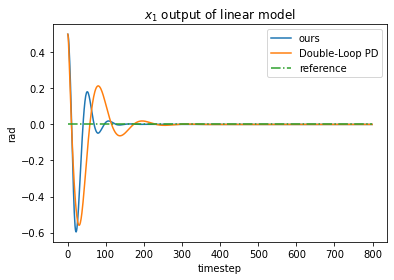

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_l[:800], label='ours') # -7.499676092201453
ax.plot(phi_l[-800:], label='Double-Loop PD') # -7.499676092201453
ax.plot([0]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_1$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x1nonlinear.png", dpi=500, format="png")

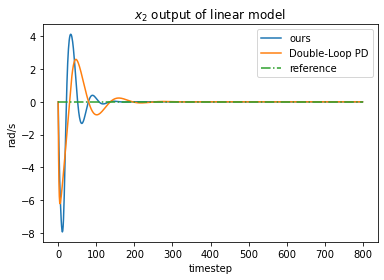

In [26]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_d_l[:800], label='ours') # -7.499676092201453
ax.plot(phi_d_l[-800:], label='Double-Loop PD')
ax.plot([0]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_2$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x2nonlinear.png", dpi=500, format="png")

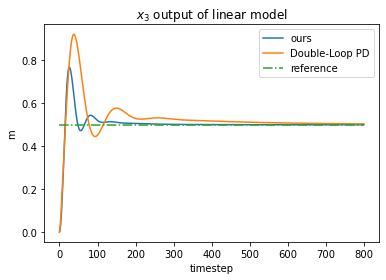

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_l[:800], label='ours') # -7.499676092201453
ax.plot(x_l[-800:], label='Double-Loop PD') # -7.499676092201453
ax.plot([0.5]*800, linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_3$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('m')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x3nonlinear.png", dpi=500, format="png")

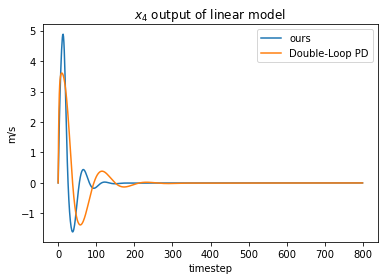

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l[:800], label='ours') # -7.499676092201453
ax.plot(x_d_l[-800:], label='Double-Loop PD') # -7.499676092201453

plt.title('$x_4$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('m/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4nonlinear.png", dpi=500, format="png")

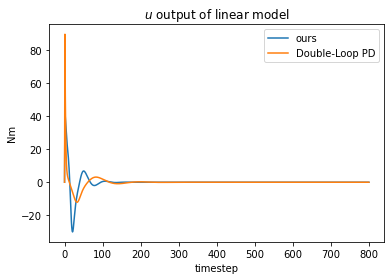

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(u_l[:800], label='ours') 
ax.plot(u_l[-800:], label='Double-Loop PD')

plt.title('$u$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('Nm')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/unonlinear.png", dpi=500, format="png")

# BO for nonlinear

In [17]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 200), 'x2': (0, 100), \
           'x3': (0, 200), 'x4': (0, 100)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=2,
)

optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
|  2        | -3.273e+0 |  84.07    |  33.03    |  40.93    |  61.93    |
|  3        | -2.547e+0 |  59.93    |  26.68    |  124.2    |  52.91    |
|  6        | -1.555e+0 |  101.0    |  6.529    |  85.62    |  9.653    |
|  12       | -447.3    |  113.4    |  42.75    |  87.35    |  77.66    |
|  24       | -249.2    |  147.7    |  65.75    |  42.93    |  41.68    |
|  26       | -70.62    |  155.6    |  13.4     |  173.8    |  74.88    |
|  54       | -63.52    |  147.8    |  19.2     |  88.21    |  41.27    |
|  68       | -53.55    |  199.7    |  30.8     |  63.58    |  45.16    |
|  90       | -50.84    |  200.0    |  37.78    |  27.61    |  22.39    |


# ablation study of nonlinear system

In [301]:
for i in range(5):
    # for ours method
    # episode_run(186.10+4*i, 34.10, 75.00, 88.18) # convergence (as well as oscillation suppression) of phi up, convergence of x down
    # episode_run(196.10, 24.10+4*i, 75.00, 88.18) # contrary to the previous
    # episode_run(196.10, 34.10, 65.00+4*i, 88.18) # covergence of phi down, oscillation down; contratry to x
    # episode_run(196.10, 34.10, 75.00, 78.18+4*i) #  contrary to previous
    
    # for double-loop PD baseline
    # episode_run(-200.1+4*i,-49.48,-30.821,-50.76) # oscillation of x and phi up, 
    # episode_run(-190.1,-59.48+4*i,-30.821,-50.76) # convergence (as well as oscillation suppression) of phi and x up
    # episode_run(-190.1,-49.48,-40.821+4*i,-50.76) # oscillation of phi and x down
    episode_run(-190.1,-49.48,-30.821,-60.76+4*i) #  convergence and oscillation down for phi; oscillation up. convergence up for x

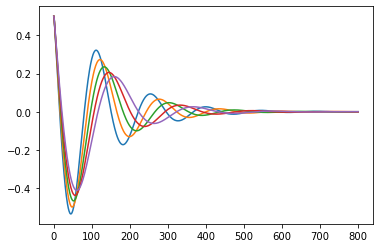

In [302]:
fig = plt.figure()
ax = fig.add_subplot()
for i in range(5):
    ax.plot(phi_l[i*801:(i+1)*801], label='ours')

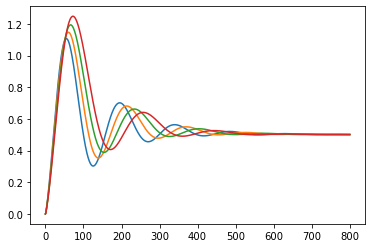

In [303]:
fig = plt.figure()
ax = fig.add_subplot()
for i in range(4):
    ax.plot(x_l[i*801:(i+1)*801], label='ours')

In [281]:
len(x_l)

8010